In [1]:

import pandas as pd
from scipy.stats import zscore

In [2]:
btc = pd.read_csv(
    "../data/processed/btc_sentiment_aligned.csv",
    parse_dates=["date"]
)

nifty = pd.read_csv(
    "../data/processed/nifty_sentiment_aligned.csv",
    parse_dates=["date"]
)

btc = btc.sort_values("date").reset_index(drop=True)
nifty = nifty.sort_values("date").reset_index(drop=True)

In [3]:
def add_market_features(df):
    df["return"] = df["close"].pct_change()
    df["volatility"] = df["return"].rolling(14).std()
    return df

btc = add_market_features(btc)
nifty = add_market_features(nifty)

In [4]:
def compute_sentiment_core(df):
    # Combine FinBERT + VADER
    return 0.7 * df["finbert_score"] + 0.3 * df["vader_score"]

def compute_sentiment_surprise(sent, window=14):
    return sent - sent.rolling(window).mean()

def compute_vol_weight(vol):
    vol_z = zscore(vol, nan_policy="omit")
    return 1 + np.maximum(0, vol_z)

In [5]:
def compute_vsi_A(df):
    df = df.copy()
    df["sent_core"] = compute_sentiment_core(df)
    df["sent_surprise"] = compute_sentiment_surprise(df["sent_core"])
    df["vol_weight"] = compute_vol_weight(df["volatility"])

    df["VSI_A"] = df["sent_surprise"] * df["vol_weight"]
    return df

In [6]:
def compute_vsi_B(df, alpha=1.0, beta=0.5):
    df = df.copy()
    df["sent_core"] = compute_sentiment_core(df)
    df["sent_surprise"] = compute_sentiment_surprise(df["sent_core"])
    df["vol_weight"] = compute_vol_weight(df["volatility"])

    df["VSI_B"] = alpha * df["sent_surprise"] + beta * df["vol_weight"]
    return df

In [7]:
def compute_vsi_C(df, beta=0.5):
    df = df.copy()
    df["sent_core"] = compute_sentiment_core(df)
    df["sent_surprise"] = compute_sentiment_surprise(df["sent_core"])
    df["vol_weight"] = compute_vol_weight(df["volatility"])

    df["VSI_C"] = df["sent_surprise"] * (1 + beta * df["vol_weight"])
    return df

In [8]:
def compute_all_vsi(df):
    df = compute_vsi_A(df)
    df = compute_vsi_B(df)
    df = compute_vsi_C(df)
    return df

btc_all = compute_all_vsi(btc)
nifty_all = compute_all_vsi(nifty)

In [9]:
btc_A = compute_vsi_A(btc)
btc_B = compute_vsi_B(btc)
btc_C = compute_vsi_C(btc)

nifty_A = compute_vsi_A(nifty)
nifty_B = compute_vsi_B(nifty)
nifty_C = compute_vsi_C(nifty)

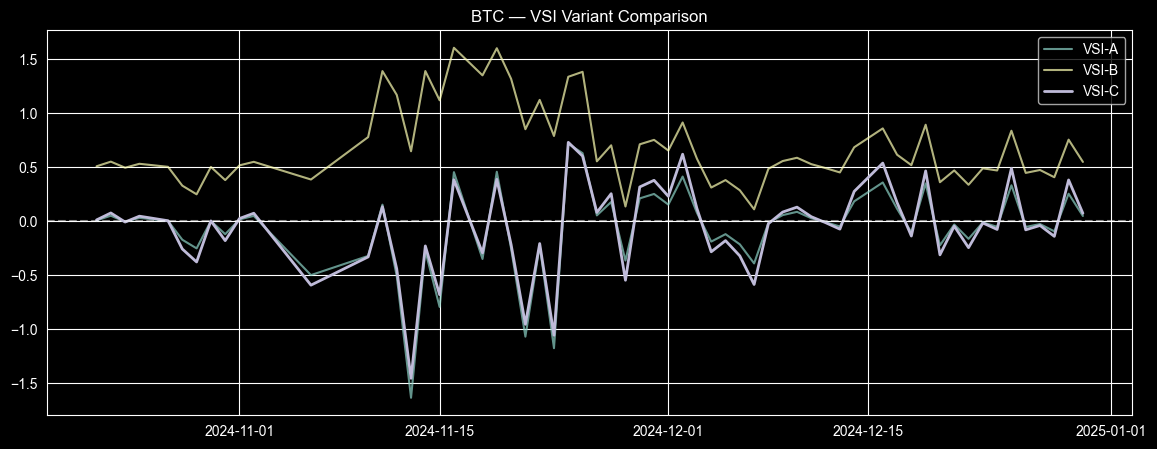

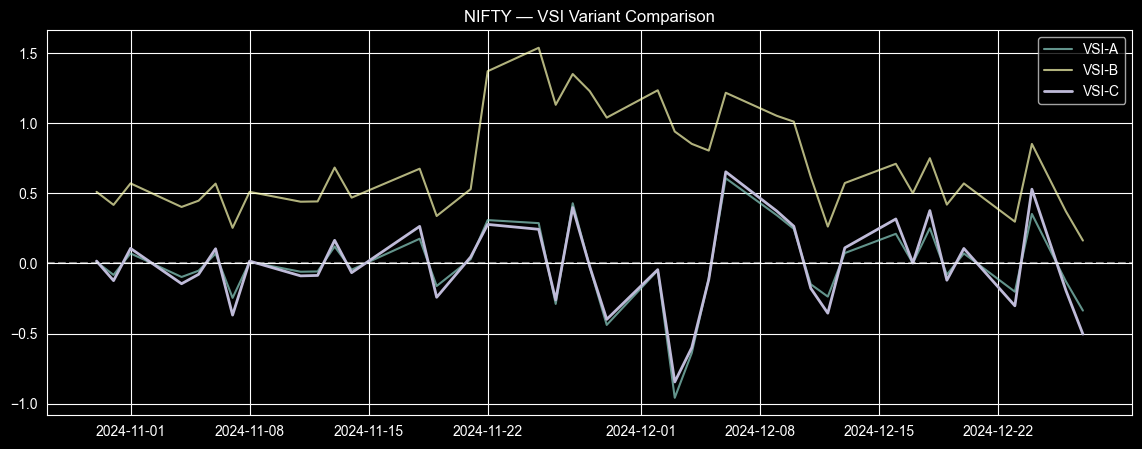

In [10]:
def plot_vsi_variants(df, asset):
    plt.figure(figsize=(14,5))
    plt.plot(df["date"], df["VSI_A"], label="VSI-A", alpha=0.7)
    plt.plot(df["date"], df["VSI_B"], label="VSI-B", alpha=0.7)
    plt.plot(df["date"], df["VSI_C"], label="VSI-C", linewidth=2)
    plt.axhline(0, color="white", linestyle="--", alpha=0.5)
    plt.title(f"{asset} — VSI Variant Comparison")
    plt.legend()
    plt.show()

plot_vsi_variants(btc_all, "BTC")
plot_vsi_variants(nifty_all, "NIFTY")

In [11]:
def vsi_stats(df, col):
    return {
        "mean": df[col].mean(),
        "std": df[col].std(),
        "kurtosis": df[col].kurtosis()
    }

for vsi in ["VSI_A", "VSI_B", "VSI_C"]:
    print("BTC", vsi, vsi_stats(btc_all, vsi))

BTC VSI_A {'mean': np.float64(-0.06584035192234777), 'std': np.float64(0.3924958645682377), 'kurtosis': np.float64(4.501494672112934)}
BTC VSI_B {'mean': np.float64(0.6834017453181978), 'std': np.float64(0.36018663394447636), 'kurtosis': np.float64(0.34997581569378555)}
BTC VSI_C {'mean': np.float64(-0.05319005338154124), 'std': np.float64(0.4006321568065838), 'kurtosis': np.float64(1.9762220672896937)}


In [12]:
from scipy.stats import pearsonr

def compare_sentiment_models(df, asset):
    print(f"\n{asset} — Model Comparison")

    # drop NaNs safely
    sub = df[["VSI_C", "finbert_score", "volatility"]].dropna()

    r_vsi, p_vsi = pearsonr(sub["VSI_C"], sub["volatility"])
    r_fb, p_fb = pearsonr(sub["finbert_score"], sub["volatility"])

    print(f"VSI → Volatility : r = {r_vsi:.3f}, p = {p_vsi:.4f}")
    print(f"FinBERT → Volatility : r = {r_fb:.3f}, p = {p_fb:.4f}")

compare_sentiment_models(btc_all, "BTC")
compare_sentiment_models(nifty_all, "NIFTY")


BTC — Model Comparison
VSI → Volatility : r = -0.271, p = 0.0349
FinBERT → Volatility : r = -0.370, p = 0.0033

NIFTY — Model Comparison
VSI → Volatility : r = -0.054, p = 0.7430
FinBERT → Volatility : r = -0.143, p = 0.3771


In [13]:
import statsmodels.api as sm

def regression_test(df, asset):
    print(f"\n{asset} — Regression Test")

    sub = df[["VSI_C", "finbert_score", "volatility"]].dropna()

    X = sub[["finbert_score", "VSI_C"]]
    X = sm.add_constant(X)
    y = sub["volatility"].shift(-1)

    model = sm.OLS(y[:-1], X[:-1]).fit()
    print(model.summary())

regression_test(btc_all, "BTC")
regression_test(nifty_all, "NIFTY")


BTC — Regression Test
                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.665
Date:                Sun, 11 Jan 2026   Prob (F-statistic):             0.0318
Time:                        20:02:19   Log-Likelihood:                 211.18
No. Observations:                  60   AIC:                            -416.4
Df Residuals:                      57   BIC:                            -410.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.031

In [14]:
import numpy as np

def bootstrap_corr(df, n=1000):
    sub = df[["VSI_C", "volatility"]].dropna()
    corrs = []

    for _ in range(n):
        samp = sub.sample(frac=1, replace=True)
        r, _ = pearsonr(samp["VSI_C"], samp["volatility"])
        corrs.append(r)

    return np.mean(corrs), np.std(corrs)

btc_mean, btc_std = bootstrap_corr(btc_all)
nifty_mean, nifty_std = bootstrap_corr(nifty_all)

print(f"BTC VSI→Vol: mean={btc_mean:.3f}, std={btc_std:.3f}")
print(f"NIFTY VSI→Vol: mean={nifty_mean:.3f}, std={nifty_std:.3f}")

BTC VSI→Vol: mean=-0.267, std=0.140
NIFTY VSI→Vol: mean=-0.050, std=0.175


In [15]:
btc_ll = btc_all[[
    "date",
    "VSI_C",
    "volatility"
]].dropna().sort_values("date").reset_index(drop=True)

nifty_ll = nifty_all[[
    "date",
    "VSI_C",
    "volatility"
]].dropna().sort_values("date").reset_index(drop=True)

In [16]:
import numpy as np

def lead_lag_corr(df, x_col, y_col, max_lag=10):
    results = {}
    for k in range(-max_lag, max_lag+1):
        if k < 0:
            x = df[x_col].iloc[-k:]
            y = df[y_col].iloc[:k]
        elif k > 0:
            x = df[x_col].iloc[:-k]
            y = df[y_col].iloc[k:]
        else:
            x = df[x_col]
            y = df[y_col]

        if len(x) > 10:  # safety
            results[k] = np.corrcoef(x, y)[0,1]
        else:
            results[k] = np.nan

    return results

In [17]:
btc_ll_corr = lead_lag_corr(
    btc_ll,
    x_col="VSI_C",
    y_col="volatility",
    max_lag=10
)

btc_ll_corr

{-10: np.float64(0.17088930270859),
 -9: np.float64(0.17640543687328794),
 -8: np.float64(0.14669725590813726),
 -7: np.float64(0.19387734960569494),
 -6: np.float64(0.10062855109011877),
 -5: np.float64(0.08846582348465326),
 -4: np.float64(-0.04590277570907794),
 -3: np.float64(-0.16675245738389322),
 -2: np.float64(-0.1695868014446073),
 -1: np.float64(-0.23271189776718415),
 0: np.float64(-0.27069473361453616),
 1: np.float64(-0.299040806364269),
 2: np.float64(-0.3431608313622728),
 3: np.float64(-0.2643132000136045),
 4: np.float64(-0.2912398367441425),
 5: np.float64(-0.3053857287338575),
 6: np.float64(-0.2741610195927597),
 7: np.float64(-0.29588706116696295),
 8: np.float64(-0.23881782688000833),
 9: np.float64(-0.2728961120299502),
 10: np.float64(-0.209792688802836)}

In [18]:
nifty_ll_corr = lead_lag_corr(
    nifty_ll,
    x_col="VSI_C",
    y_col="volatility",
    max_lag=10
)

btc_ll_corr

{-10: np.float64(0.17088930270859),
 -9: np.float64(0.17640543687328794),
 -8: np.float64(0.14669725590813726),
 -7: np.float64(0.19387734960569494),
 -6: np.float64(0.10062855109011877),
 -5: np.float64(0.08846582348465326),
 -4: np.float64(-0.04590277570907794),
 -3: np.float64(-0.16675245738389322),
 -2: np.float64(-0.1695868014446073),
 -1: np.float64(-0.23271189776718415),
 0: np.float64(-0.27069473361453616),
 1: np.float64(-0.299040806364269),
 2: np.float64(-0.3431608313622728),
 3: np.float64(-0.2643132000136045),
 4: np.float64(-0.2912398367441425),
 5: np.float64(-0.3053857287338575),
 6: np.float64(-0.2741610195927597),
 7: np.float64(-0.29588706116696295),
 8: np.float64(-0.23881782688000833),
 9: np.float64(-0.2728961120299502),
 10: np.float64(-0.209792688802836)}

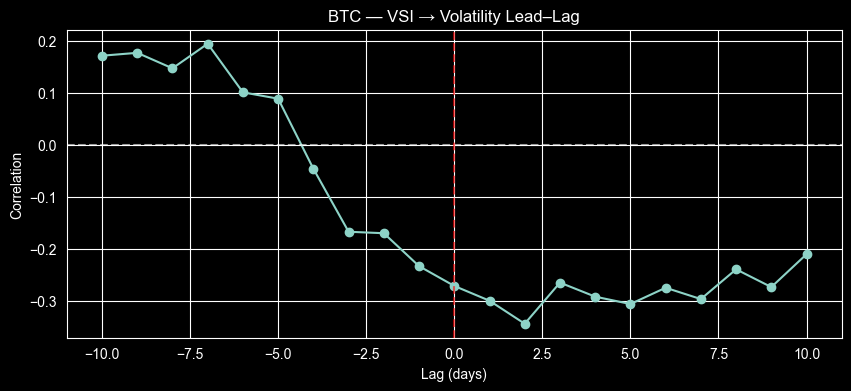

In [19]:
import matplotlib.pyplot as plt

lags = list(btc_ll_corr.keys())
vals = list(btc_ll_corr.values())

plt.figure(figsize=(10,4))
plt.plot(lags, vals, marker="o")
plt.axhline(0, color="white", linestyle="--", alpha=0.6)
plt.axvline(0, color="red", linestyle="--", alpha=0.6)
plt.title("BTC — VSI → Volatility Lead–Lag")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.show()

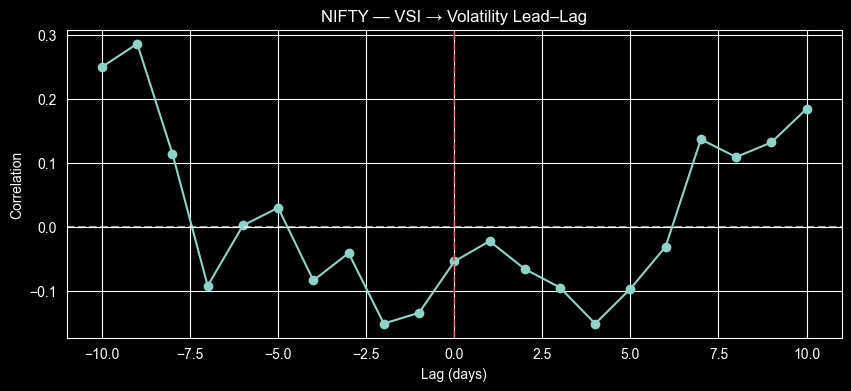

In [20]:
import matplotlib.pyplot as plt

lags = list(nifty_ll_corr.keys())
vals = list(nifty_ll_corr.values())

plt.figure(figsize=(10,4))
plt.plot(lags, vals, marker="o")
plt.axhline(0, color="white", linestyle="--", alpha=0.6)
plt.axvline(0, color="red", linestyle="--", alpha=0.6)
plt.title("NIFTY — VSI → Volatility Lead–Lag")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.show()